In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.modelling import VAE

2023-12-14 22:11:33,317 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



# Load Data

In [2]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-14 22:11:33,658 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-14 22:11:47,645 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [3]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-14 22:11:47,658 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-14 22:11:47,789 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-14 22:11:47,794 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.14s) ...


(430, 250, 7)


# Modelling

In [4]:
vae = VAE(tensor=tensor, latent_dims=2, reconstruction_weight=3)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

2023-12-14 22:11:47,950 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2023-12-14 22:11:48,630 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-14 22:11:48,691 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\engine\base_layer_utils.py:189: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [5]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               271364    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 250, 7)            19262     
                                                                 
Total params: 290632 (1.11 MB)
Trainable params: 290626 (1.11 MB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [6]:
# TODO: Add callbacks, for EarlyStopping and LR Reduce
history = vae.fit(tensor, epochs=16, batch_size=1, validation_split=0.2, shuffle=True)

Epoch 1/16
344/344 [==============================] - 35s 92ms/step - loss: 85.7333 - reconstruction_loss: 12.9562 - kl_loss: 1.2649 - val_loss: 12.9920 - val_reconstruction_loss: 4.2933 - val_kl_loss: 0.1120
Epoch 2/16
344/344 [==============================] - 31s 89ms/step - loss: 11.8990 - reconstruction_loss: 3.8940 - kl_loss: 0.0347 - val_loss: 10.1139 - val_reconstruction_loss: 3.3663 - val_kl_loss: 0.0151
Epoch 3/16
344/344 [==============================] - 30s 88ms/step - loss: 11.4605 - reconstruction_loss: 3.7456 - kl_loss: 0.0709 - val_loss: 10.9257 - val_reconstruction_loss: 3.5415 - val_kl_loss: 0.3013
Epoch 4/16
344/344 [==============================] - 30s 88ms/step - loss: 11.1189 - reconstruction_loss: 3.6625 - kl_loss: 0.1735 - val_loss: 10.7197 - val_reconstruction_loss: 3.4747 - val_kl_loss: 0.2955
Epoch 5/16
344/344 [==============================] - 30s 88ms/step - loss: 11.2003 - reconstruction_loss: 3.5905 - kl_loss: 0.2779 - val_loss: 11.4870 - val_reconstru

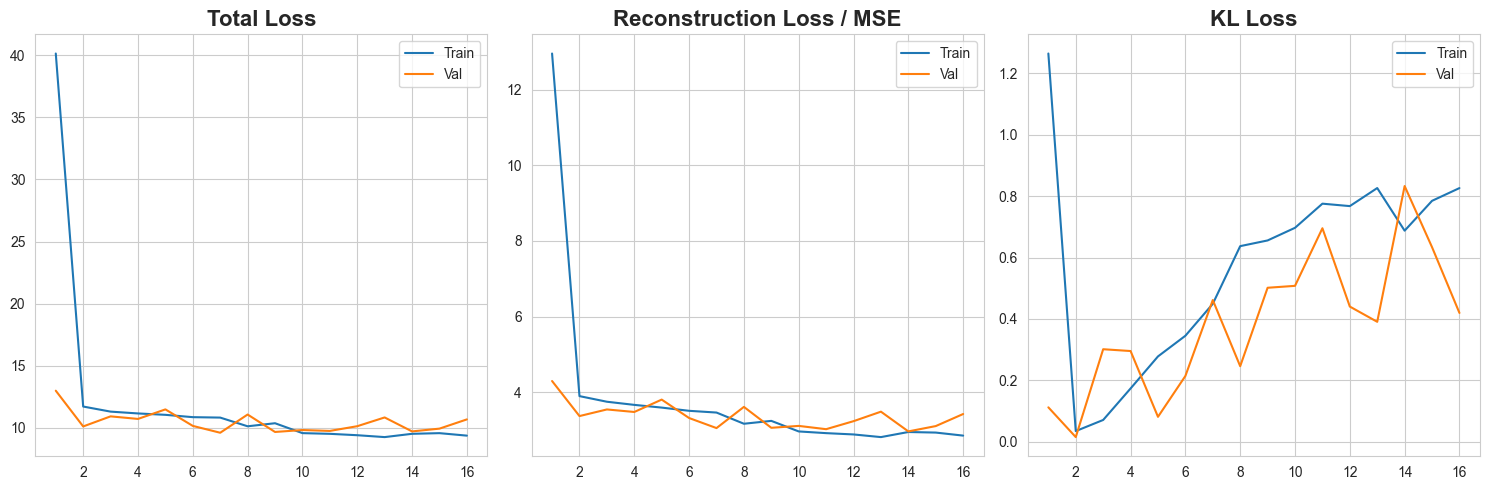

In [7]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss / MSE", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [8]:
#vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Reconstruction Plotting

In [9]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [10]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 1s 804ms/step


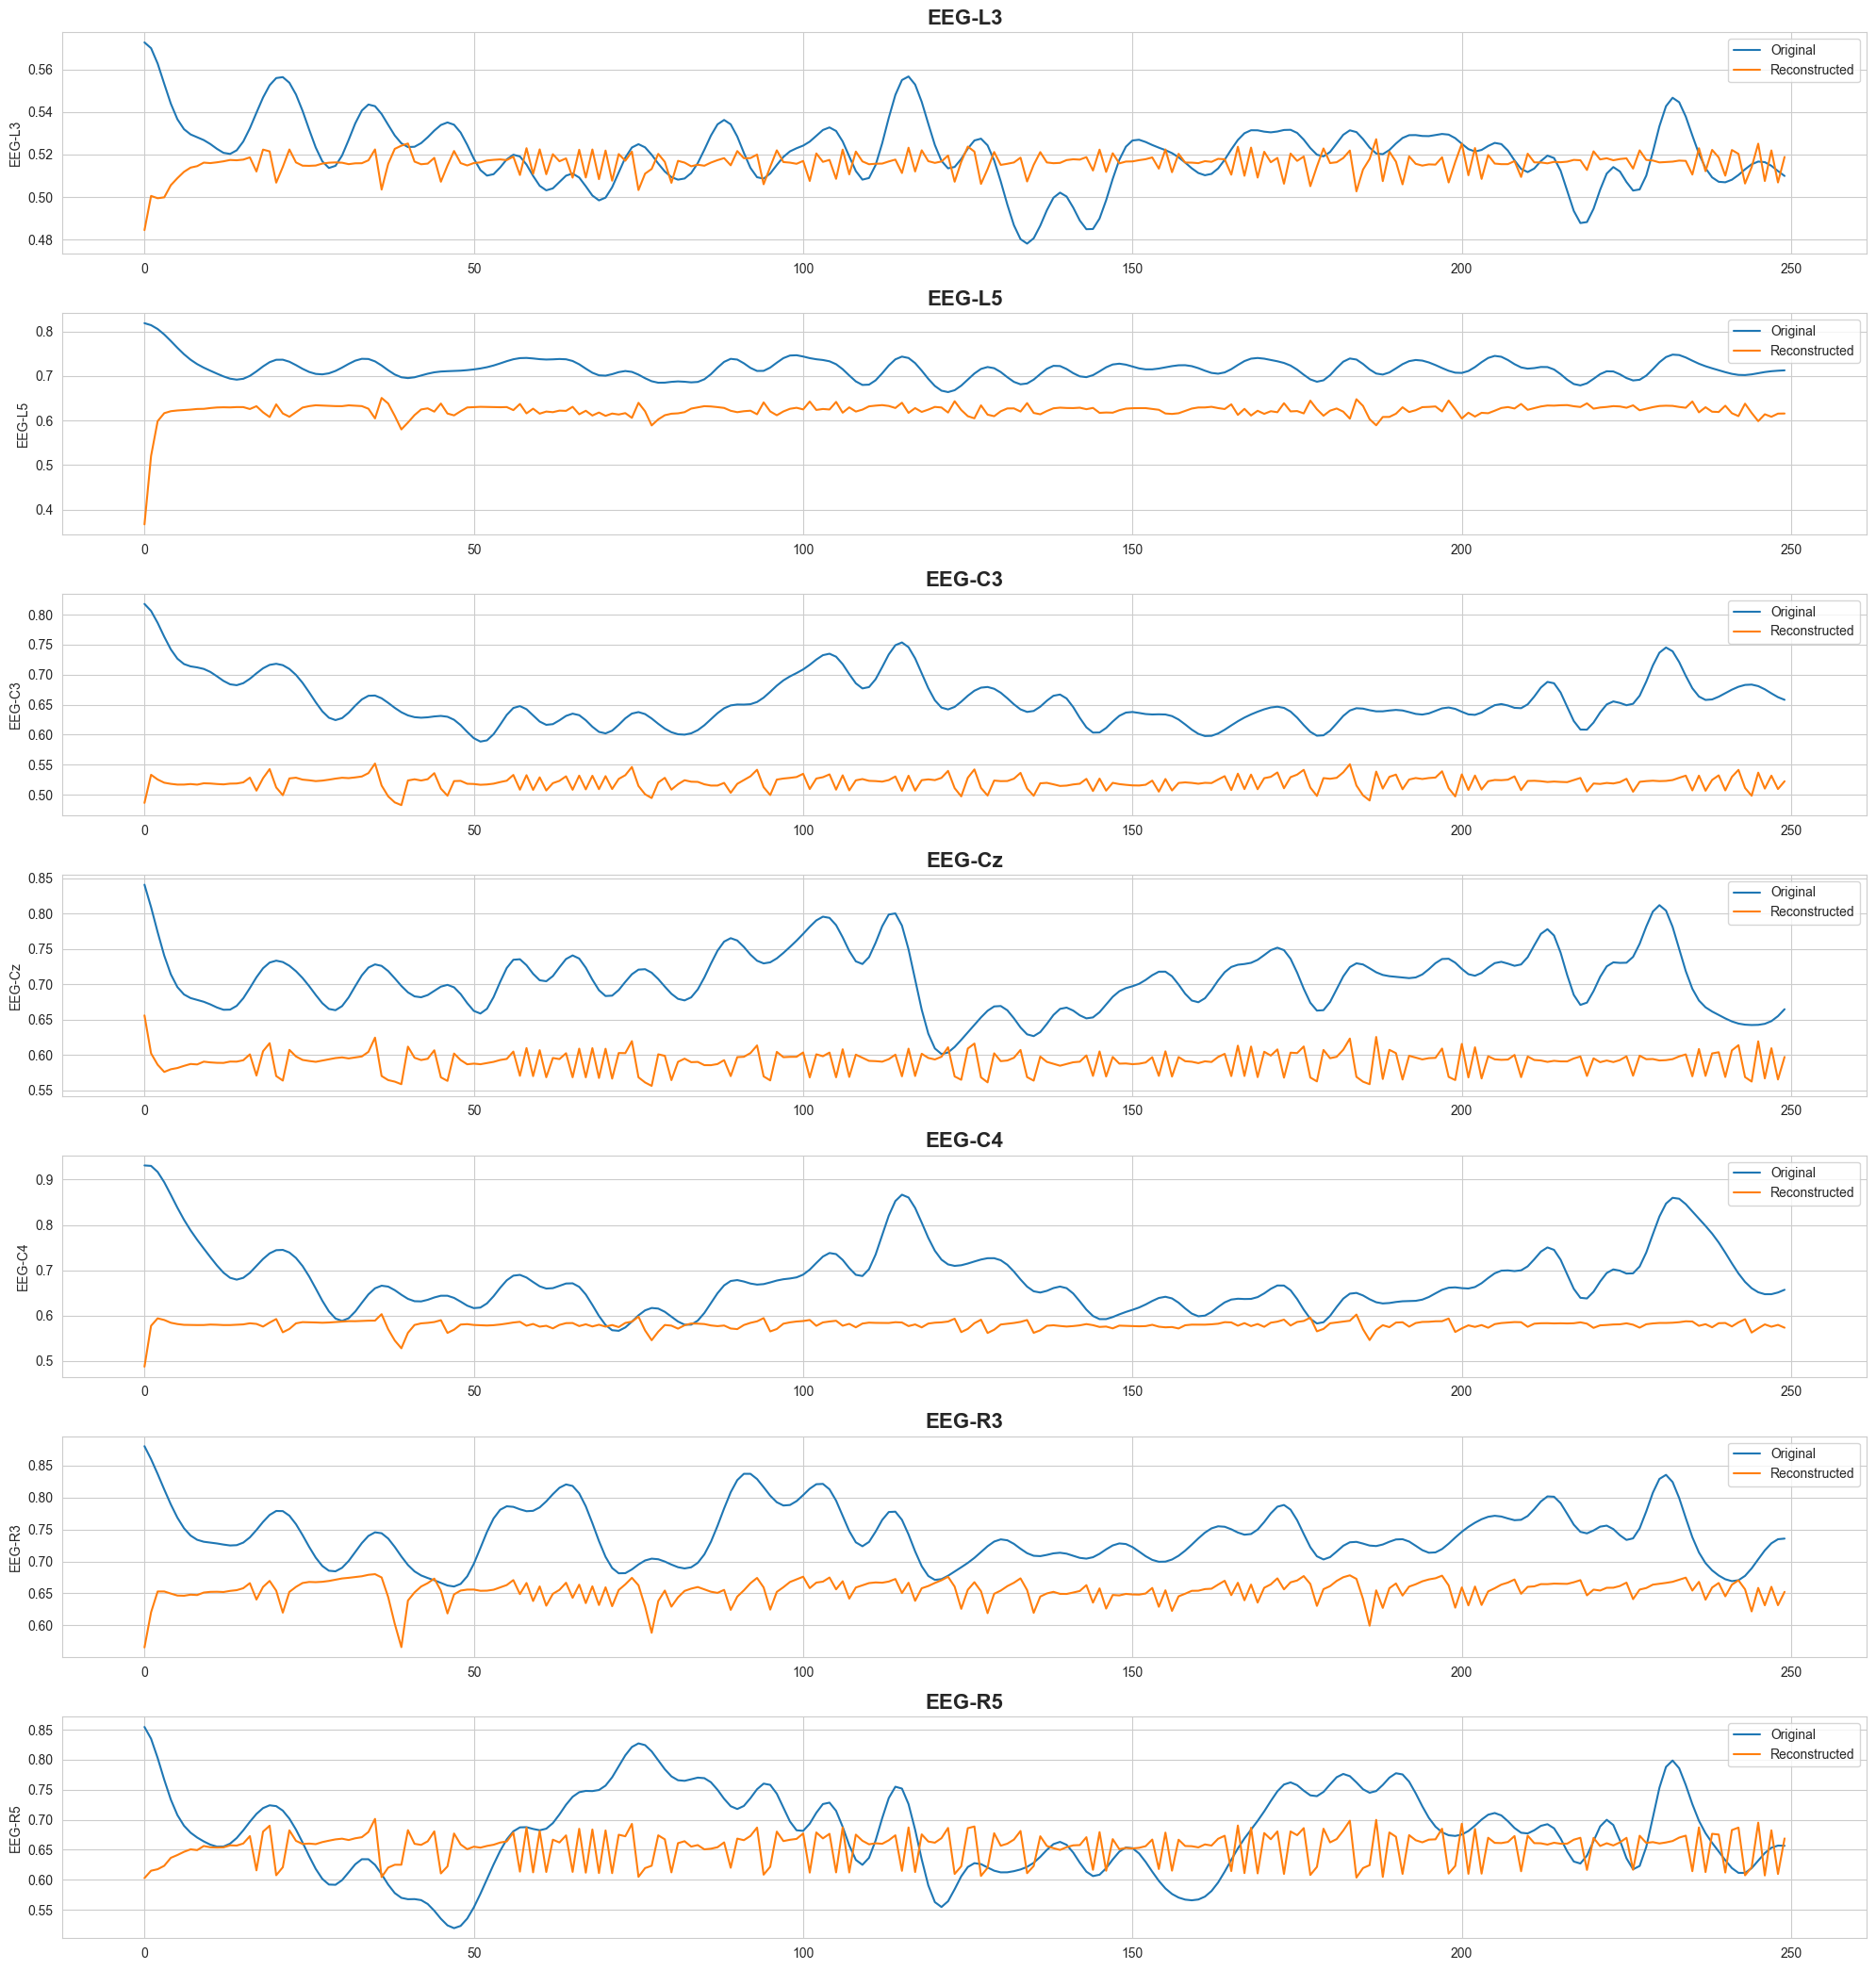

In [11]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [12]:
z_mean, z_log_var, z = vae.encoder.predict(tensor)

14/14 [==============================] - 1s 56ms/step


In [13]:
z.shape

(430, 2)

In [14]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

# Generate synthetic time series data
num_samples = 1
synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, 2)
print(synthetic_time_series.shape)

1/1 [==============================] - 0s 40ms/step
Latent Samples: [[1.45223095 0.12819637]]
(1, 250, 7)


In [15]:
test = synthetic_time_series[0]
test.shape

(250, 7)

In [16]:
test_df = pd.DataFrame(test, columns=FEATURE_NAMES)#, index=df_scaled_list[0].index)
test_df

,EEG-L3,EEG-L5,EEG-C3,EEG-Cz,EEG-C4,EEG-R3,EEG-R5
0,0.478902,0.382214,0.473725,0.637614,0.485093,0.563760,0.591156
1,0.495087,0.525904,0.527971,0.594142,0.576988,0.619452,0.607781
2,0.496414,0.596972,0.522690,0.581983,0.592374,0.647860,0.612593
3,0.498094,0.611929,0.518150,0.573704,0.588136,0.645475,0.619296
4,0.504102,0.615699,0.516077,0.577490,0.581860,0.640911,0.631786
...,...,...,...,...,...,...,...
245,0.523196,0.602105,0.531399,0.613337,0.571198,0.652687,0.686995
246,0.507339,0.607505,0.509849,0.566151,0.576748,0.622760,0.609885
247,0.520386,0.609669,0.527546,0.605087,0.574361,0.653848,0.675761
248,0.506757,0.608395,0.509252,0.564979,0.575768,0.622496,0.611817


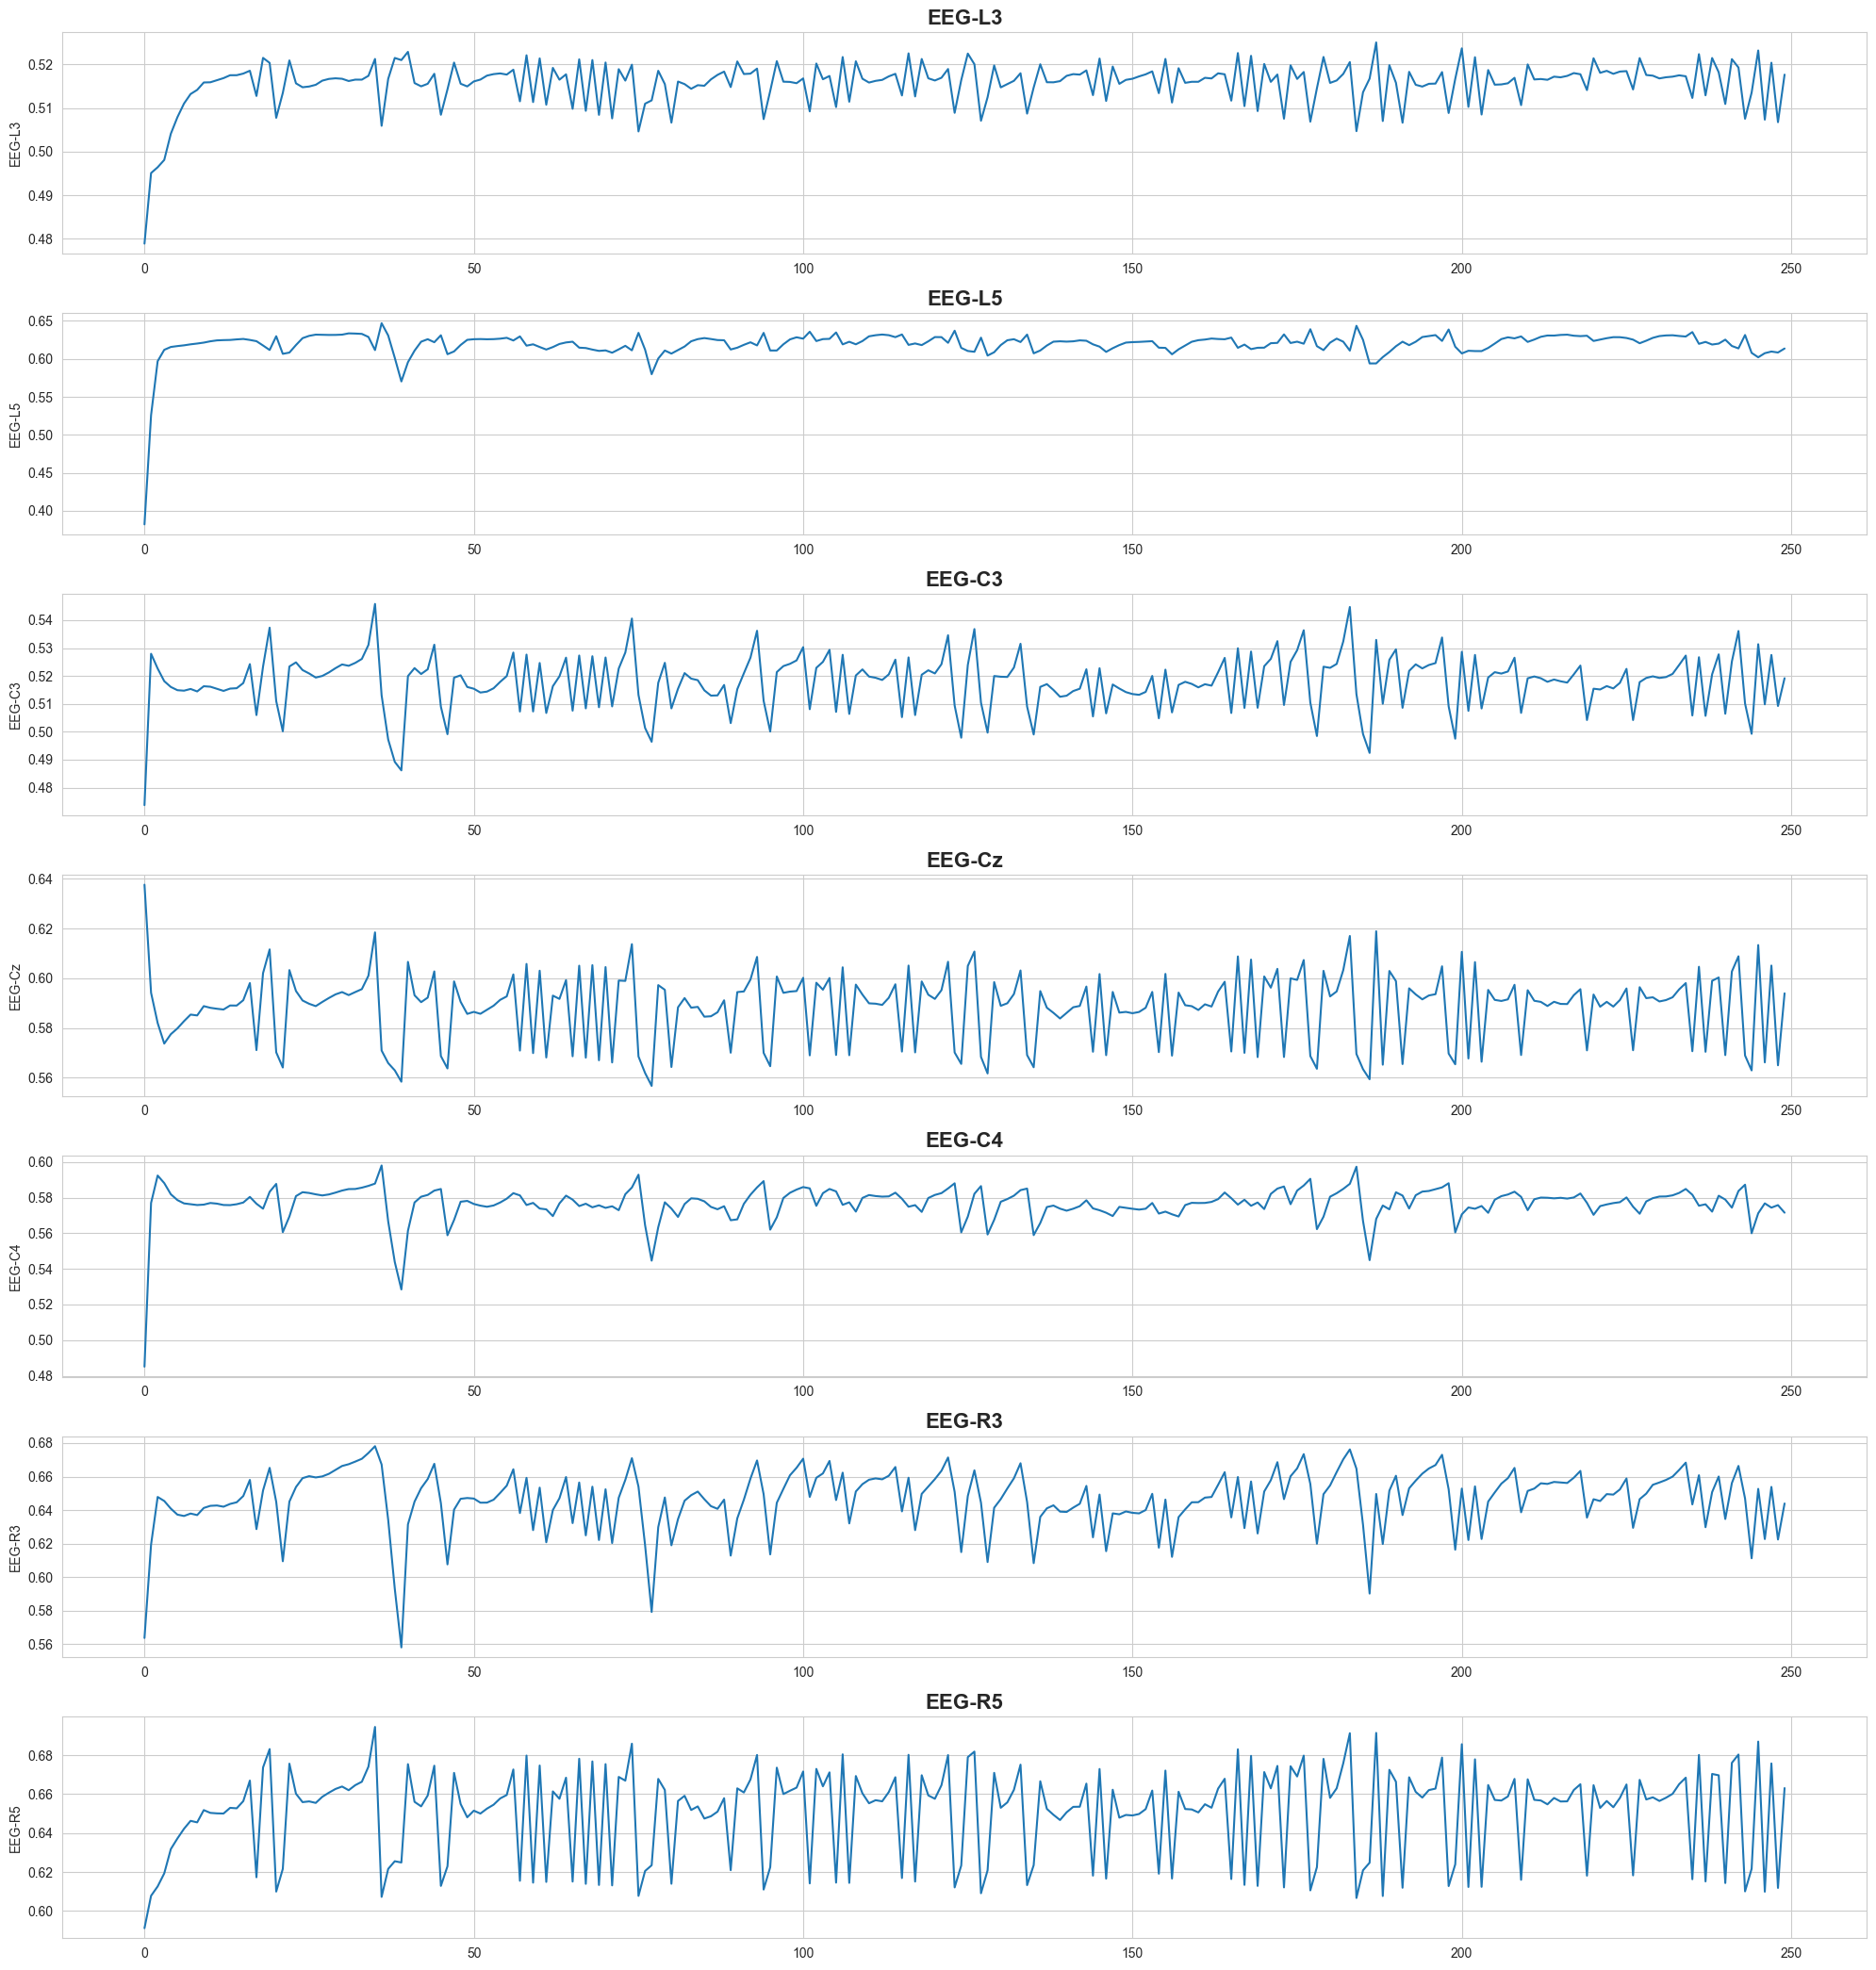

In [17]:
def plot_all_time_series(df: pd.DataFrame) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.startswith("EEG")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*3))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(test_df)